In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import copy
import pickle


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier
import graphviz

from utilities import getFraudData, computeLearningCurve, plotScoreCurve, plotTimeCurve, plotIterationCurve, plotConfusionMatrix, getDrawData, drawIncorrectSketches, heatmap

In [3]:
# Name of data file
datafile = "./data/creditcard.csv"

# Random seed used for all "random" generators
randomSeed = 1

# Number of parallel jobs used for some sklearn routines (-1 means use all cpus)
njobs = -1

# Fractional of (y=1) cases held out for testing
testSize = 0.5

# Integer number of non-fraud cases kept in the training set
nonFraudInTraining = 5000

# Number of folds for GridSearchCV
nfolds = 5

# Number of samples (fraudulent, not fraudulent)
nSamples = (492, 125000)

# Plot min/max extents for all accuracy plots
accuracyMin = 0.6
accuracyMax = 1.0

names = ["Not Fraud", "Fraud"]

# # Folds (denoted by number of data points used) for learning curve
learningCurveFolds = np.concatenate([np.geomspace(31, 316, 4).round(), np.array([500, 1000, 2000, 3000])]).astype('int')
# learningCurveFolds = np.array([500, 1000, 2000, 3000]).astype('int')

# Fraction of data held out from the training dataset for cross validation during learning curve evaluation
lcTestSize = 0.2

In [4]:
# Used for plot names
est = "fraud_dt"
scoreText = "F1-Score"

In [5]:
data = getFraudData(datafile, nSamples, randomSeed)
print(f"Got data of shape: {data.shape}")

featColNames = [name for name in data.columns if ((name != "Class") and (name != "Time"))] 

print(f"Got feature columns {featColNames}")

Importing data with 492 fraudulent and 125000 not fraudulent cases
Got data of shape: (125492, 31)
Got feature columns ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


In [6]:
# Create X, y, XTest, yTest
# Because of the imbalance in data, use half of the fraud cases and only 5000 of the non-fraud cases for training.  Then Test on the rest

fraudXFull = data.loc[data.Class == 1, featColNames].values
fraudyFull = data.loc[data.Class == 1, 'Class'].values

fraudX, fraudXTest, fraudy, fraudyTest = train_test_split(fraudXFull, fraudyFull, 
                                                      test_size=testSize, random_state=randomSeed)

notFraudXFull = data.loc[data.Class == 0, featColNames].values
notFraudyFull = data.loc[data.Class == 0, 'Class'].values

# Using train_test_split "backwards" because I want 5000 examples in my training set and the rest in test
notFraudXTest, notFraudX, notFraudyTest, notFraudy = train_test_split(notFraudXFull, notFraudyFull, 
                                                      test_size=nonFraudInTraining, random_state=randomSeed)

print('')
print(f'fraudX.shape = {fraudX.shape}')
print(f'fraudy.shape = {fraudy.shape}')
print(f'Ratio of y=1 to y=0 for Training data: {(fraudy == 1).sum() / float(len(fraudy))} (should be 1)')

print('')
print(f'notFraudX.shape = {notFraudX.shape}')
print(f'notFraudy.shape = {notFraudy.shape}')
print(f'Ratio of y=1 to y=0 for Training data: {(notFraudy == 1).sum() / float(len(notFraudy))} (should be 1)')

XUnscaled = np.concatenate([fraudX, notFraudX])
XTestUnscaled = np.concatenate([fraudXTest, notFraudXTest])

# Scale X, XTest for use in learning algorithm 
scaler = StandardScaler()
X = scaler.fit_transform(XUnscaled)
XTest = scaler.transform(XTestUnscaled)

y = np.concatenate([fraudy, notFraudy])
yTest = np.concatenate([fraudyTest, notFraudyTest])

print('')
print(f'X.shape = {X.shape}')
print(f'y.shape = {y.shape}')
print(f'Ratio of yTest=1 to yTest=0 for Test data: {(y == 1).sum() / float(len(y))} (should be ~0.05)')

print('')
print(f'XTest.shape = {XTest.shape}')
print(f'yTest.shape = {yTest.shape}')
print(f'Ratio of yTest=1 to yTest=0 for Test data: {(yTest == 1).sum() / float(len(yTest))} (should be ~.001)')



fraudX.shape = (246, 29)
fraudy.shape = (246,)
Ratio of y=1 to y=0 for Training data: 1.0 (should be 1)

notFraudX.shape = (5000, 29)
notFraudy.shape = (5000,)
Ratio of y=1 to y=0 for Training data: 0.0 (should be 1)

X.shape = (5246, 29)
y.shape = (5246,)
Ratio of yTest=1 to yTest=0 for Test data: 0.04689287075867327 (should be ~0.05)

XTest.shape = (120246, 29)
yTest.shape = (120246,)
Ratio of yTest=1 to yTest=0 for Test data: 0.0020458060975001246 (should be ~.001)


# Initial Parameter Grid Search

In [7]:
paramGrid = {
    'min_samples_split': [2, 3, 4] + list(range(5, 26, 5)) + list(range(30, 51, 10)) + list(range(75, 301, 25)),
#     'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 30, 40, 50] + list(range(75, 401, 25))
}

nData = -1 # (all)
XSubset = X[:nData]
ySubset = y[:nData]

gs = GridSearchCV(DecisionTreeClassifier(criterion='entropy', random_state=randomSeed), param_grid=paramGrid, cv=nfolds, n_jobs=njobs, 
                      verbose=10, return_train_score=True, scoring='f1')

In [8]:
# fit!
print(f"Fitting model using {XSubset.shape[0]} data samples")
gs.fit(XSubset, ySubset)

pltNameSuffix = '_' + '_initial'
with open(est + pltNameSuffix + "_gs.pkl", 'wb') as fout:
    pickle.dump(gs, file=fout)

Fitting model using 5245 data samples
Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 101 out of 105 | elapsed:   16.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:   16.6s finished


In [9]:
gs_results_df = pd.DataFrame(gs.cv_results_)
gs_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.128448,0.010614,0.001197,3.997581e-04,2,{'min_samples_split': 2},0.823529,0.840000,0.854369,0.860000,...,0.839580,0.015980,21,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,0.176744,0.029687,0.001197,3.985174e-04,3,{'min_samples_split': 3},0.823529,0.848485,0.854369,0.860000,...,0.848699,0.013155,20,1.000000,0.997455,0.997455,1.000000,0.994898,0.997962,0.001908
2,0.215423,0.016437,0.001995,1.705984e-06,4,{'min_samples_split': 4},0.823529,0.884211,0.862745,0.909091,...,0.869103,0.028130,17,1.000000,0.992366,0.989848,0.994949,0.992327,0.993898,0.003451
3,0.249732,0.020042,0.002194,3.993755e-04,5,{'min_samples_split': 5},0.807692,0.865979,0.862745,0.909091,...,0.857095,0.033315,19,0.989691,0.987212,0.989848,0.994949,0.984615,0.989263,0.003425
4,0.264692,0.016885,0.001795,3.994228e-04,10,{'min_samples_split': 10},0.840000,0.884211,0.865385,0.877551,...,0.866056,0.015167,18,0.976623,0.968750,0.977444,0.962406,0.966057,0.970256,0.005894
5,0.290224,0.020681,0.001996,1.942782e-06,15,{'min_samples_split': 15},0.831683,0.895833,0.865385,0.905263,...,0.877882,0.026625,15,0.971722,0.930481,0.977444,0.951654,0.949602,0.956181,0.016840
6,0.306780,0.026256,0.001796,7.453731e-04,20,{'min_samples_split': 20},0.865979,0.895833,0.873786,0.905263,...,0.882639,0.015153,13,0.949333,0.931217,0.972292,0.940568,0.950131,0.948708,0.013644
7,0.313562,0.017027,0.001994,6.311283e-04,25,{'min_samples_split': 25},0.865979,0.895833,0.909091,0.893617,...,0.891160,0.014029,2,0.949333,0.931217,0.958974,0.929134,0.950131,0.943758,0.011614
8,0.309971,0.021580,0.003191,2.917586e-03,30,{'min_samples_split': 30},0.854167,0.895833,0.863158,0.893617,...,0.877174,0.016423,16,0.931880,0.931217,0.945170,0.929134,0.938667,0.935213,0.005918
9,0.343881,0.026971,0.001994,1.764942e-06,40,{'min_samples_split': 40},0.854167,0.895833,0.872340,0.893617,...,0.879011,0.015223,14,0.928962,0.931217,0.939633,0.929134,0.938667,0.933522,0.004673


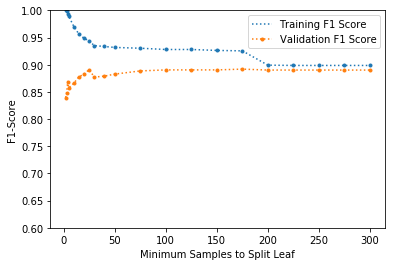

In [10]:
fig, ax = plt.subplots()

gs_results_df.plot(x='param_min_samples_split', y='mean_train_score', label='Training F1 Score', ax=ax, marker='.', ls=":")
gs_results_df.plot(x='param_min_samples_split', y='mean_test_score', label='Validation F1 Score', ax=ax, marker='.', ls=":")
gs_results_df.to_csv(est + pltNameSuffix + "gs_results.csv")

ax.set_xlabel("Minimum Samples to Split Leaf")
ax.set_ylabel(scoreText)
ax.set_ylim(bottom=accuracyMin, top=accuracyMax)

fig.savefig(est + pltNameSuffix + "_gs")

In [11]:
print(f'From this, we choose the following parameters for computing the learning curve:\n{gs.best_params_}')
yPred =  gs.best_estimator_.predict(X)
print(f'On the training data, we see precision and recall of:')
cr = classification_report(y, yPred, target_names=['Not Fraud', 'Fraud'])
print(cr)
print(f'but for the held-out test data we obtain just:')
yPred =  gs.best_estimator_.predict(XTest)
cr = classification_report(yTest, yPred, target_names=['Not Fraud', 'Fraud'])
print(cr)

From this, we choose the following parameters for computing the learning curve:
{'min_samples_split': 175}
On the training data, we see precision and recall of:
             precision    recall  f1-score   support

  Not Fraud       0.99      1.00      1.00      5000
      Fraud       0.99      0.87      0.93       246

avg / total       0.99      0.99      0.99      5246

but for the held-out test data we obtain just:
             precision    recall  f1-score   support

  Not Fraud       1.00      1.00      1.00    120000
      Fraud       0.61      0.76      0.67       246

avg / total       1.00      1.00      1.00    120246



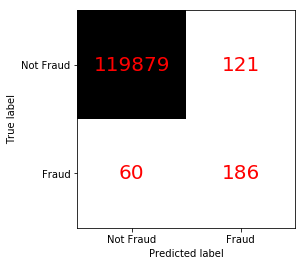

In [12]:
predictions = gs.predict(XTest)
ax = plotConfusionMatrix(yTest, predictions, names, savefig=est + pltNameSuffix + "_confusion")

In [13]:
dt_full = copy.deepcopy(gs.best_estimator_)
dt_full.min_samples_split = 2 # Reset back to default
dt_full.fit(XSubset, ySubset) # Remake full tree
print(f'The full tree has {dt_full.tree_.node_count} nodes')

vis = tree.export_graphviz(dt_full, out_file=None, filled=True, proportion=False)
graph = graphviz.Source(vis)
graph.render(est + pltNameSuffix + "_full")

dt_pruned = gs.best_estimator_
print(f'The pruned tree has {dt_pruned.tree_.node_count} nodes')

vis = tree.export_graphviz(dt_pruned, out_file=None, filled=True, proportion=False)
graph = graphviz.Source(vis)
graph.render(est + pltNameSuffix + "_pruned")

The full tree has 85 nodes
The pruned tree has 31 nodes


'fraud_dt__initial_pruned.pdf'

# Learning Curves

Produce learning curves (train/test accuracy vs number of examples and train/score time vs number of examples) using the above chosen parameters to determine:

* Whether the classifier is bias or variance limited
* Limit to which more data points will not be helpful

This is repeated for both linear and rbf kernels

NOTE: UndefinedMetricWarnings may occur below in some cases with small data due to poor classification

In [14]:
lc_params = copy.deepcopy(gs.best_params_)

lcNameBase = est + "_lc_" + str(len(learningCurveFolds)) + "f_" + str(X.shape[0]) + "ex"
lcName = lcNameBase  + ".pkl"

print(f"Computing learning curves with params: \n{lc_params}")
print(f"Over {len(learningCurveFolds)} folds: {learningCurveFolds}")
# Note that computeLearningCurve with testSize specified splits X, y into a test and validation set 
# before training (validation set is used for validation curve)
lc = computeLearningCurve(DecisionTreeClassifier(criterion='entropy', random_state=randomSeed, **lc_params), X, y, testSize = lcTestSize,
                         scorer=f1_score, learningCurveFolds=learningCurveFolds, stratifyLearningCurveFolds=True, 
                         randomSeed=randomSeed, saveas=lcName, returnEstimators=True)

Computing learning curves with params: 
{'min_samples_split': 175}
Over 8 folds: [  31   67  146  316  500 1000 2000 3000]
Indices included at fold 0: 31
	Model trained in 0.00s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.00s
	Total time for this iteration = 0.00s
Indices included at fold 1: 67
	Model trained in 0.00s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.00s
	Total time for this iteration = 0.00s
Indices included at fold 2: 146
	Model trained in 0.00s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.00s
	Total time for this iteration = 0.00s
Indices included at fold 3: 316
	Model trained in 0.00s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.00s
	Total time for this iteration = 0.01s
Indices included at fold 4: 500
	Model trained in 0.01s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.00s
	Total time for this iteration = 0.01s
Indices included at fold

C:\Users\Scribs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


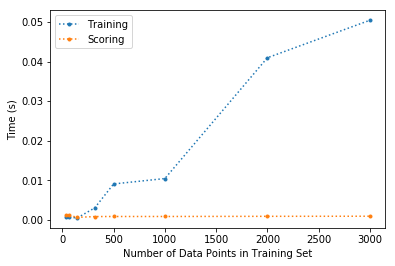

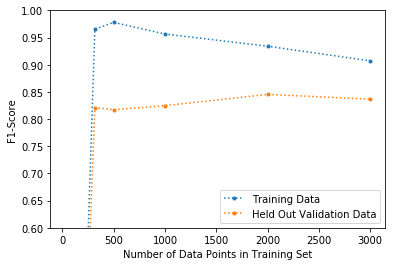

In [15]:
plotTimeCurve(lc, savefig = lcNameBase + "_time")
# plt.legend()
plt.show()

plotScoreCurve(lc, bottom=accuracyMin, top=accuracyMax, ylabel = scoreText, savefig = lcNameBase + "_score")
# plt.legend()
plt.show()

In [16]:
iBest = np.argmax(lc['test_score'])
bestScore = lc['test_score'][iBest]
bestData = lc['n_data'][iBest]
print(f'Best validation score of {bestScore:.3} achieved with {bestData:d} samples')

Best validation score of 0.845 achieved with 2000 samples
